# Exapmle using Multiple-shooting method for constructing periodic orbit

Yuri Shimane, 2021/07/06

In [2]:
using LinearAlgebra
using DifferentialEquations
using Plots

In [3]:
gr()

Plots.GRBackend()

In [4]:
include("../R3BP/src/R3BP.jl")

Main.R3BP

In [5]:
# ODE settings throughout this notebook
reltol = 1.e-13
abstol = 1.e-13
method = Tsit5()

Tsit5()

We start by constructing an initial guess, here for a Sun-Venus L2 halo of 260,000 km out-of-plane amplitude.

Halo guess Az_km: 260000.0


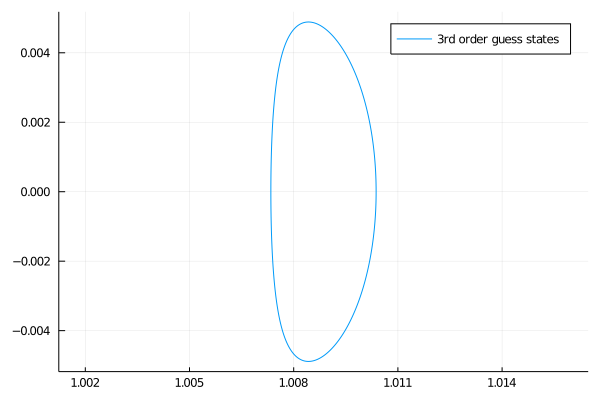

In [29]:
# construct halo initial guess
CR3BP_param = R3BP.get_cr3bp_param(10, 299)
lp = 2
Az_km = 260*1e3
println("Halo guess Az_km: $Az_km")
northsouth = 3   # 1 or 3
guess0 = R3BP.halo_analytical_construct(CR3BP_param.mu, lp, Az_km, CR3BP_param.lstar, northsouth)
plot(guess0.fullstates[:,1], guess0.fullstates[:,2], aspect_ratio=:equal, label="3rd order guess states")

We then need to manipulate the resulting initial guess into a format that is used by the multiple shooting algorithm. Let `n` be the number of nodes to be used by the multiple-shooting algoriyhm, then we need to provide a list of `n` states along the trajectory, and `n-1` times over which the 1st ~ (n-1)th state will be integrated. 

In [11]:
# number of data in initial guess array
n_data, _ = size(guess0.fullstates)

# number of nodes to use
n = 6

# get index to extract from 3rd order initial guess state-history
skip_idx = Int(floor(500/(n-1)))
extract_idx = []
for i = 1:skip_idx:n_data
    push!(extract_idx, i)
end
# append final node for periodic orbit
push!(extract_idx, 1)

# get x0s, states along the trajectory
x0s = []
for i = 1:n
    extract_idx[i]
    push!(x0s, guess0.fullstates[extract_idx[i], 1:6])
end

# get tofs, propagation of the first ~ (n-1)th state
tofs = []
for i = 1:n-1
    if i != n-1
        tof = guess0.fullstates[extract_idx[i+1], 7] - guess0.fullstates[extract_idx[i], 7]
    else
        tof = guess0.period - guess0.fullstates[extract_idx[i], 7]
    end
    push!(tofs, tof)
end

n, length(x0s), length(tofs)

(6, 6, 5)

We also construct an `ODEProblem` to supply the dynamical system which will be used by the multiple-shooting algorithm to integrate the nodes. Note that the function `R3BP.rhs_cr3bp_svstm!` propagates both the state-vector and the state-transition matrix (STM). 

Since we want to visualize the initial guess (which is not periodic yet!), we will also call `solve` on the initial guess. 

In [20]:
# construct initial ODE problem
μ = CR3BP_param.mu
prob_stm = ODEProblem(R3BP.rhs_cr3bp_svstm!, 
    vcat(guess0.x0, reshape(I(6), (36,)))[:], guess0.period, (μ));
# propagate initial guess for plotting later
sol = solve(prob_stm, method, reltol=reltol, abstol=abstol)
solig = R3BP.sol_to_arrays(sol);   # obtain state-history as array for plotting

We now call `R3BP.multiple_shooting`; since we are looking for a periodic solution, we set `periodic=true`, which forces the initial node to overlap with the final node. 

In [22]:
# solve with multiple-shooting
tolDC = 1.e-13   # tolerance to be achieved by multiple-shooting algorithm
x0_conv, tof_conv = R3BP.multiple_shooting(prob_stm, x0s, tofs, tolDC; 
    periodic=true, reltol=reltol, abstol=abstol);

Multiple-shooting using 6 nodes, periodic: true
Multiple shooting iteration 1, error = 0.006620753837688195
Multiple shooting iteration 2, error = 0.00020983098061856125
Multiple shooting iteration 3, error = 2.187940939081456e-6
Multiple shooting iteration 4, error = 7.381910877005488e-9
Tolerance achieved at iteration 5 with error = 2.213458542523518e-14


We can now propagate the converged result by a full period, and plot the result of the multiple-shooting. We can also compare it with the initial guess propagated by a full period. 

In [23]:
# propagate converged result of multiple-shooting
prob = ODEProblem(R3BP.rhs_cr3bp_sv!, x0_conv[1:6], sum(tof_conv), (μ))
sol = solve(prob, Tsit5(), reltol=reltol, abstol=abstol);
solmsdc = R3BP.sol_to_arrays(sol);   # obtain state-history as array for plotting

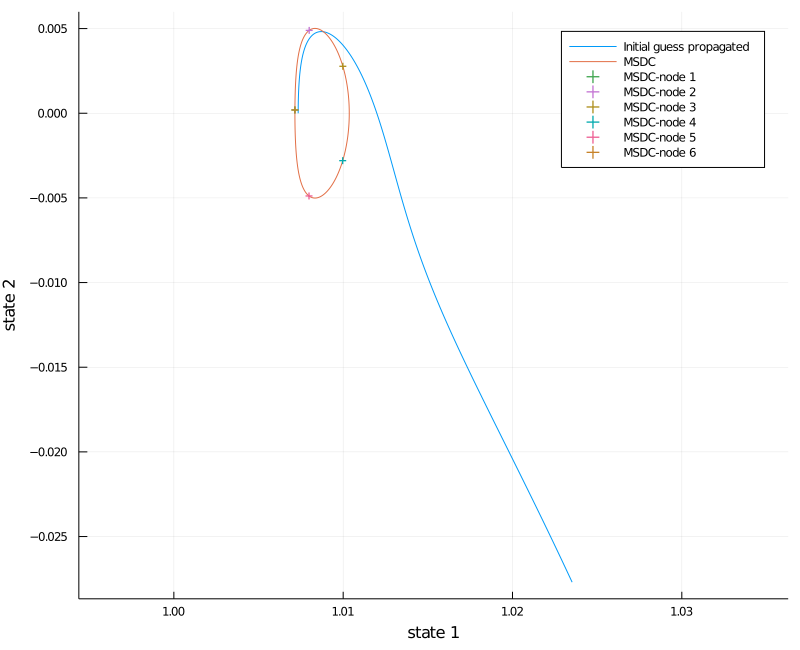

In [32]:
# create plot of trajectory
idx1, idx2 = 1, 2
ptraj = plot(flip=false, aspect_ratio=:equal, size=(800,650), 
             xlabel="state $idx1", ylabel="state $idx2", grid=true)

plot!(ptraj, solig[idx1,:], solig[idx2,:], label="Initial guess propagated")
plot!(ptraj, solmsdc[idx1,:], solmsdc[idx2,:], label="MSDC")

# plot nodes used by multiple-shooting algorithm
for i = 1:n
    scatter!(ptraj, [x0_conv[(i-1)*6+1:6i][idx1]], [x0_conv[(i-1)*6+1:6i][idx2]], 
        label="MSDC-node $i", marker=(:cross, 3.5, 3.5))
end
ptraj